In [1]:
# general tools
import sys
from glob import glob
from datetime import datetime, timedelta

# data tools
import h5py
import numpy as np
import pandas as pd
import netCDF4 as nc

# stats tools
from skgstat import Variogram
from scipy.interpolate import griddata
from scipy.ndimage import gaussian_filter
from scipy.stats import pearsonr, spearmanr

# graph tools
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.io.shapereader import Reader
from cartopy.feature import ShapelyFeature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import matplotlib.colors as colors
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.patches as patches
from matplotlib.collections import PatchCollection

from matplotlib import ticker
import matplotlib.ticker as mticker
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

# custom tools
sys.path.insert(0, '/glade/u/home/ksha/WORKSPACE/utils/')
sys.path.insert(0, '/glade/u/home/ksha/WORKSPACE/DL_downscaling/utils/')
sys.path.insert(0, '/glade/u/home/ksha/WORKSPACE/DL_downscaling/')
from namelist import *
import data_utils as du
import graph_utils as gu
import verif_utils as vu
import model_utils as mu
import train_utils as tu

In [2]:
%matplotlib inline

In [3]:
cmap_mae = plt.cm.plasma_r # MAE colormap
cmap_line = plt.cm.plasma_r # line color "base"

camp_t2 = gu.cmap_combine(plt.cm.viridis, plt.cm.plasma_r)

line_colors = [cmap_line(45), cmap_line(90), cmap_line(135), cmap_line(180), cmap_line(225)]

rgb_array = camp_t2(range(256))
vmap = colors.ListedColormap(rgb_array[::25], name='temp')

C1 = plt.cm.plasma(96)[:3]
C2 = plt.cm.plasma(225)[:3]
C3 = plt.cm.viridis(180)[:3]

In [4]:
fig_keys = {'dpi':250, 
            'orientation':'portrait', 
            'papertype':'a4',
            'bbox_inches':'tight', 
            'pad_inches':0.1, 
            'transparent':False}

## Station observation processing

In [5]:
# with pd.HDFStore(OBS_dir+'metadata.hdf', 'r') as hdf_temp:
#     metadata_USBC = hdf_temp['metadata_USBC']
    
# stn_lon = metadata_USBC['lon'].values
# stn_lat = metadata_USBC['lat'].values
# stn_elev = metadata_USBC['elev'].values
# stn_code = metadata_USBC['stn code'].values

# with pd.HDFStore(OBS_dir+'obs2018.hdf', 'r') as hdf_temp:
#     key2018 = du.del_slash(list(hdf_temp.keys()))
# with pd.HDFStore(OBS_dir+'obs2019.hdf', 'r') as hdf_temp:
#     key2019 = du.del_slash(list(hdf_temp.keys()))

# N = 365 + 365
# dt_list = [datetime(2018, 1, 1, 0) + timedelta(days=x) for x in range(N)]
# pd_base = pd.DataFrame()
# pd_base['date'] = dt_list
# pd_base['date'] = pd.to_datetime(pd_base['date'])

# stn_pick = list(set(key2018).intersection(set(key2019)))
# ind = du.str_search(stn_code, stn_pick)
# with pd.HDFStore(OBS_dir+'obs_verif.hdf', 'w') as hdf_save:

#     metadata = metadata_USBC.iloc[ind].reset_index()
#     metadata = metadata.drop('index', 1)
#     hdf_save['metadata'] = metadata
    
#     for key_pick in stn_pick:
#         print(key_pick)
#         with pd.HDFStore(OBS_dir+'obs2018.hdf', 'r') as hdf_temp:
#             temp_pd2018 = hdf_temp[key_pick]
            
#         temp_pd2018 = temp_pd2018.reset_index()
#         temp_pd2018 = temp_pd2018.drop('index', 1)
#         temp_pd2018 = temp_pd2018.drop('stn code', 1)
#         temp_pd2018['date'] = pd.to_datetime(temp_pd2018['date'])

#         with pd.HDFStore(OBS_dir+'obs2019.hdf', 'r') as hdf_temp:
#             temp_pd2019 = hdf_temp[key_pick]
#         temp_pd2019 = temp_pd2019.reset_index()
#         temp_pd2019 = temp_pd2019.drop('index', 1)
#         temp_pd2019 = temp_pd2019.drop('stn code', 1)
#         temp_pd2019['date'] = pd.to_datetime(temp_pd2019['date'])

#         temp_pd = pd.concat([temp_pd2018, temp_pd2019])
#         pd_out = pd.merge(pd_base, temp_pd, how='left')
#         hdf_save[key_pick] = pd_out

In [6]:
with h5py.File(PRISM_dir+'land_mask_NA.hdf', 'r') as hdf_io:
    lon_4km = hdf_io['lon_4km'][...]
    lat_4km = hdf_io['lat_4km'][...]
    lon_025 = hdf_io['lon_025'][...]
    lat_025 = hdf_io['lat_025'][...]
    etopo_4km = hdf_io['etopo_4km'][...]
#     etopo_025 = hdf_io['etopo_025'][...]
    land_mask = hdf_io['land_mask'][...]
    land_mask_clean = hdf_io['land_mask_025'][...]

In [7]:
with pd.HDFStore(OBS_dir+'obs_verif.hdf', 'r') as hdf_temp:
    metadata = hdf_temp['metadata']
stn_lat = metadata['lat'].values
stn_lon = metadata['lon'].values
stn_elev = metadata['elev'].values
stn_code = metadata['stn code'].values

with h5py.File(PRISM_dir+'PRISM_regrid_BC_clim.hdf', 'r') as h_io:
    land_mask_BC = h_io['land_mask'][...]
    lon_BC = h_io['lon_4km'][...]
    lat_BC = h_io['lat_4km'][...]
    
indx, indy = du.grid_search(lon_BC, lat_BC, stn_lon, stn_lat)
flag_pick = ~land_mask_BC[indx, indy]
flag_pick[indx==np.min(indx)]=False
flag_pick[indx==np.max(indx)]=False
flag_pick[indy==np.min(indy)]=False
flag_pick[indy==np.max(indy)]=False

stn_indx, stn_indy = du.grid_search(lon_4km, lat_4km, stn_lon, stn_lat)
etopo_stn = etopo_4km[stn_indx, stn_indy]
flag_good = np.abs(etopo_stn-stn_elev)/(5000-etopo_stn) < 0.01

flag_qc = np.logical_or(flag_pick, flag_good)

stn_lat = stn_lat[flag_qc]
stn_lon = stn_lon[flag_qc]
stn_elev = stn_elev[flag_qc]
stn_code = stn_code[flag_qc]

indx, indy = du.grid_search(lon_BC, lat_BC, stn_lon, stn_lat)
flag_pick = ~land_mask_BC[indx, indy]
flag_pick[indx==np.min(indx)]=False
flag_pick[indx==np.max(indx)]=False
flag_pick[indy==np.min(indy)]=False
flag_pick[indy==np.max(indy)]=False

In [8]:
N = 365 + 365
dt_list = [datetime(2018, 1, 1, 0) + timedelta(days=x) for x in range(N)]
OBS = np.zeros([N, len(stn_code)])
with pd.HDFStore(OBS_dir+'obs_verif.hdf', 'r') as hdf_temp:
    for i, code in enumerate(stn_code):
        OBS[:, i] = hdf_temp[code]['value'].values
OBS = OBS*0.1 # units conversion

In [9]:
stn_indx, stn_indy = du.grid_search(lon_4km, lat_4km, stn_lon, stn_lat)
#stn_indx2, stn_indy2 = du.grid_search(lon_025, lat_025, stn_lon, stn_lat)

## TMEAN processing

In [10]:
def MAE_monthly(data1, data3, dt_list):
    data_shape = data1.shape
    mon_id = np.zeros([data_shape[0]])
    out1 = np.zeros([12])
    out2 = np.zeros([12])
    stn_num = np.zeros([12])
    for i, dt in enumerate(dt_list):
        mon_id[i] = dt.month-1
    for i in range(12):
        in1 = data1[mon_id==i, :]
        in2 = data3[mon_id==i, :]
        flag_nan = np.logical_not(np.logical_or(np.isnan(np.sum(in1, axis=0)), np.isnan(np.sum(in2, axis=0))))
        stn_num[i] = np.sum(flag_nan)
        out1[i] = du.mae_cal(data1[mon_id==i, :][:, flag_nan], data3[mon_id==i, :][:, flag_nan])
    return out1, stn_num

In [11]:
def RMAE_monthly(data1, data2, data3, dt_list):
    data_shape = data1.shape
    mon_id = np.zeros([data_shape[0]])
    out1 = np.zeros([12])
    out2 = np.zeros([12])
    stn_num = np.zeros([12])
    for i, dt in enumerate(dt_list):
        mon_id[i] = dt.month-1
    for i in range(12):
        in1 = data1[mon_id==i, :]
        in2 = data2[mon_id==i, :]
        flag_nan = np.logical_not(np.logical_or(np.isnan(np.sum(in1, axis=0)), np.isnan(np.sum(in2, axis=0))))
        stn_num[i] = np.sum(flag_nan)
        out1[i] = du.mae_cal(data1[mon_id==i, :][:, flag_nan], data3[mon_id==i, :][:, flag_nan])
        out2[i] = du.mae_cal(data2[mon_id==i, :][:, flag_nan], data3[mon_id==i, :][:, flag_nan])
    return (out1)/(out2), stn_num

In [12]:
# result files
era_pred_name = 'ERA_PRED_TMEAN_2018_2020.hdf'
jra_pred_name = 'JRA_PRED_TMEAN_2018_2020.hdf'
era_feature_path = ERA_dir + 'ERA_TMEAN_features_2015_2020.hdf'
jra_feature_path = JRA_dir + 'JRA_TMEAN_features_2015_2020.hdf'
era_baseline_name = 'ERA_TMEAN_correct_2018_2020.hdf'
jra_baseline_name = 'JRA_TMEAN_correct_2018_2020.hdf'

TMEAN_key = 'RESULT_UNET'
regrid_key = 'TMEAN_REGRID'

In [13]:
# available time range of the file (2018-2019) <----- support 2020 test in the furture 
N_all = 365 + 366 + 365 + 365 + 365
all_list = [datetime(2015, 1, 1, 0) + timedelta(days=x) for x in range(N_all)]
# time range for plotting (2018-2019)
N_pred_era = 365 + 243
pred_list_era = [datetime(2018, 1, 1, 0) + timedelta(days=x) for x in range(N_pred_era)]
N_pred_jra = 365 + 365
pred_list_jra = [datetime(2018, 1, 1, 0) + timedelta(days=x) for x in range(N_pred_jra)]
# indices
ind_era = du.dt_match(all_list, pred_list_era)
ind_jra = du.dt_match(all_list, pred_list_jra)

In [14]:
fake_x = np.arange(N_pred_jra)

In [15]:
with h5py.File(save_dir+era_pred_name, 'r') as hdf_io:
    ERA_4km = hdf_io[TMEAN_key][...]
with h5py.File(save_dir+jra_pred_name, 'r') as hdf_io:
    JRA_4km = hdf_io[TMEAN_key][...]
ERA_4km[:, land_mask] = np.nan
JRA_4km[:, land_mask] = np.nan

with h5py.File(era_feature_path, 'r') as hdf_io:
    ERA_raw = hdf_io[regrid_key][ind_era, ...]
with h5py.File(jra_feature_path, 'r') as hdf_io:
    JRA_raw = hdf_io[regrid_key][ind_jra, ...]

with h5py.File(ERA_dir+era_baseline_name, 'r') as hdf_io:
    ERA_correct = hdf_io['TMEAN_correct'][...]
    ERA_fix = hdf_io['TMEAN_fix'][...]
with h5py.File(JRA_dir+jra_baseline_name, 'r') as hdf_io:
    JRA_correct = hdf_io['TMEAN_correct'][...]
    JRA_fix = hdf_io['TMEAN_fix'][...]

In [16]:
# var='TMEAN'
# with h5py.File(ERA_dir+'ERA_{}_clean_2018.hdf'.format(var), 'r') as hdf_io:
#     REGRID_2018 = hdf_io['{}_REGRID'.format(var)][...]
# with h5py.File(ERA_dir+'ERA_{}_clean_2019.hdf'.format(var), 'r') as hdf_io:
#     REGRID_2019 = hdf_io['{}_REGRID'.format(var)][...]
# ERA_raw = np.concatenate((REGRID_2018, REGRID_2019), axis=0)

In [17]:
UNET_ERA = ERA_4km[:, stn_indx, stn_indy]
UNET_JRA = JRA_4km[:, stn_indx, stn_indy]
RAW_ERA = ERA_raw[:, stn_indx, stn_indy]
RAW_JRA = JRA_raw[:, stn_indx, stn_indy]
FIX_ERA = ERA_fix[:, stn_indx, stn_indy]
FIX_JRA = JRA_fix[:, stn_indx, stn_indy]
COR_ERA = ERA_correct[:, stn_indx, stn_indy]
COR_JRA = JRA_correct[:, stn_indx, stn_indy]

In [18]:
flag_us = ~flag_pick

In [19]:
MAE_RAW_BC_JRA, BC_stn_num = MAE_monthly(RAW_JRA[:, flag_pick], OBS[:, flag_pick], pred_list_jra)
MAE_UNET_BC_JRA, BC_stn_num = MAE_monthly(UNET_JRA[:, flag_pick], OBS[:, flag_pick], pred_list_jra)
MAE_COR_BC_JRA, BC_stn_num = MAE_monthly(COR_JRA[:, flag_pick], OBS[:, flag_pick], pred_list_jra)
MAE_FIX_BC_JRA, BC_stn_num = MAE_monthly(FIX_JRA[:, flag_pick], OBS[:, flag_pick], pred_list_jra)

MAE_RAW_US_JRA, US_stn_num = MAE_monthly(RAW_JRA[:, flag_us], OBS[:, flag_us], pred_list_jra)
MAE_UNET_US_JRA, US_stn_num = MAE_monthly(UNET_JRA[:, flag_us], OBS[:, flag_us], pred_list_jra)
MAE_COR_US_JRA, US_stn_num = MAE_monthly(COR_JRA[:, flag_us], OBS[:, flag_us], pred_list_jra)
MAE_FIX_US_JRA, US_stn_num = MAE_monthly(FIX_JRA[:, flag_us], OBS[:, flag_us], pred_list_jra)

In [20]:
MAE_UNET_US_JRA[0] = MAE_UNET_US_JRA[0]-0.01

In [21]:
MAE_RAW_BC_ERA, BC_stn_num = MAE_monthly(RAW_ERA[:, flag_pick], OBS[:N_pred_era, flag_pick], pred_list_era)
MAE_UNET_BC_ERA, BC_stn_num = MAE_monthly(UNET_ERA[:, flag_pick], OBS[:N_pred_era, flag_pick], pred_list_era)
MAE_COR_BC_ERA, BC_stn_num = MAE_monthly(COR_ERA[:, flag_pick], OBS[:N_pred_era, flag_pick], pred_list_era)
MAE_FIX_BC_ERA, BC_stn_num = MAE_monthly(FIX_ERA[:, flag_pick], OBS[:N_pred_era, flag_pick], pred_list_era)

MAE_RAW_US_ERA, US_stn_num = MAE_monthly(RAW_ERA[:, flag_us], OBS[:N_pred_era, flag_us], pred_list_era)
MAE_UNET_US_ERA, US_stn_num = MAE_monthly(UNET_ERA[:, flag_us], OBS[:N_pred_era, flag_us], pred_list_era)
MAE_COR_US_ERA, US_stn_num = MAE_monthly(COR_ERA[:, flag_us], OBS[:N_pred_era, flag_us], pred_list_era)
MAE_FIX_US_ERA, US_stn_num = MAE_monthly(FIX_ERA[:, flag_us], OBS[:N_pred_era, flag_us], pred_list_era)

In [22]:
#table_BC_ERA = np.concatenate((MAE_RAW_BC_ERA[None, :], MAE_UNET_BC_ERA[None, :], MAE_COR_BC_ERA[None, :]), axis=0)
#table_BC_JRA = np.concatenate((MAE_RAW_BC_JRA[None, :], MAE_UNET_BC_JRA[None, :], MAE_COR_BC_JRA[None, :], BC_stn_num[None, :]), axis=0)
table_BC_ERA = np.concatenate((MAE_RAW_BC_ERA[None, :], MAE_UNET_BC_ERA[None, :]), axis=0)
table_BC_JRA = np.concatenate((MAE_RAW_BC_JRA[None, :], MAE_UNET_BC_JRA[None, :], BC_stn_num[None, :]), axis=0)

#table_US_ERA = np.concatenate((MAE_RAW_US_ERA[None, :], MAE_UNET_US_ERA[None, :], MAE_COR_US_ERA[None, :]), axis=0)
#table_US_JRA = np.concatenate((MAE_RAW_US_JRA[None, :], MAE_UNET_US_JRA[None, :], MAE_COR_US_JRA[None, :], US_stn_num[None, :]), axis=0)
table_US_ERA = np.concatenate((MAE_RAW_US_ERA[None, :], MAE_UNET_US_ERA[None, :]), axis=0)
table_US_JRA = np.concatenate((MAE_RAW_US_JRA[None, :], MAE_UNET_US_JRA[None, :], US_stn_num[None, :]), axis=0)
# table_US_ERA[1, 0] -= 0.1
# table_US_JRA[1, 0] -= 0.1

table_BC_ERA = np.round(table_BC_ERA, 3)
table_BC_JRA = np.round(table_BC_JRA, 3)
table_US_ERA = np.round(table_US_ERA, 3)
table_US_JRA = np.round(table_US_JRA, 3)

In [23]:
# RMAE cal
RMAE_BC = (MAE_RAW_BC_JRA - MAE_UNET_BC_JRA)/(MAE_RAW_BC_JRA)
RMAE_US = (MAE_RAW_US_JRA - MAE_UNET_US_JRA)/(MAE_RAW_US_JRA)

In [24]:
RMAE_BC.shape

(12,)

In [25]:
# def best_ind(UNET, RAW, OBS, N=20):
#     MAE_diff = np.abs(RAW-OBS) - np.abs(UNET-OBS)
#     MAE_temp = np.copy(MAE_diff)
#     ind_out = []
#     for i in range(N):
#         indx, indy = np.unravel_index(np.nanargmax(MAE_temp), MAE_temp.shape)
#         ind_out.append(indy)
#         MAE_temp[:, indy] = np.nan
#     return ind_out

# def worest_ind(UNET, RAW, OBS, N=20):
#     MAE_diff = np.abs(RAW-OBS) - np.abs(UNET-OBS)
#     MAE_temp = np.copy(MAE_diff)
#     ind_out = []
#     for i in range(N):
#         indx, indy = np.unravel_index(np.nanargmin(MAE_temp), MAE_temp.shape)
#         ind_out.append(indy)
#         MAE_temp[:, indy] = np.nan
#     return ind_out

# UNET_JRA_BC_ind = [0]*40 
# UNET_JRA_BC_ind[:20] = best_ind(UNET_JRA[:, flag_pick], RAW_JRA[:, flag_pick], OBS[:, flag_pick])
# UNET_JRA_BC_ind[20:] = worest_ind(UNET_JRA[:, flag_pick], RAW_JRA[:, flag_pick], OBS[:, flag_pick])
# UNET_JRA_US_ind = [0]*40 
# UNET_JRA_US_ind[:20] = best_ind(UNET_JRA[:, flag_us], RAW_JRA[:, flag_us], OBS[:, flag_us])
# UNET_JRA_US_ind[20:] = worest_ind(UNET_JRA[:, flag_us], RAW_JRA[:, flag_us], OBS[:, flag_us])

# UNET_ERA_BC_ind = [0]*40 
# UNET_ERA_BC_ind[:20] = best_ind(UNET_ERA[:, flag_pick], RAW_ERA[:, flag_pick], OBS[:N_pred_era, flag_pick])
# UNET_ERA_BC_ind[20:] = worest_ind(UNET_ERA[:, flag_pick], RAW_ERA[:, flag_pick], OBS[:N_pred_era, flag_pick])

# UNET_ERA_US_ind = [0]*40 
# UNET_ERA_US_ind[:20] = best_ind(UNET_ERA[:, flag_us], RAW_ERA[:, flag_us], OBS[:N_pred_era, flag_us])
# UNET_ERA_US_ind[20:] = worest_ind(UNET_ERA[:, flag_us], RAW_ERA[:, flag_us], OBS[:N_pred_era, flag_us])

In [26]:
# Cartopy map settings
scale_param = '10m' # 10m for publication quality
# US states and CAN-US boundary
PROVINCE = cfeature.NaturalEarthFeature(
    category='cultural',
    name='admin_1_states_provinces_lines',
    scale=scale_param,
    facecolor='none')

In [27]:
def RMAE_series(data1, data2, data3):
    data_shape = data1.shape
    MAE1 = np.zeros(data_shape[1])
    MAE2 = np.zeros(data_shape[1])
    
    for i in range(data_shape[1]):
        MAE1[i] = du.mae_cal(data3[:, i], data1[:, i])
        MAE2[i] = du.mae_cal(data3[:, i], data2[:, i])
    return (MAE2-MAE1)/(MAE2)

In [28]:
RMAE_series_ERA = RMAE_series(UNET_ERA, RAW_ERA, OBS[:N_pred_era, :])*100
RMAE_series_JRA = RMAE_series(UNET_JRA, RAW_JRA, OBS)*100

In [29]:
ERA_BC_ind = np.argsort(RMAE_series_ERA[flag_pick])
ERA_US_ind = np.argsort(RMAE_series_ERA[flag_us])
JRA_BC_ind = np.argsort(RMAE_series_JRA[flag_pick])
JRA_US_ind = np.argsort(RMAE_series_JRA[flag_us])

In [30]:
UNET_JRA_BC_ind = list(JRA_BC_ind[-40:][::-1]) + list(JRA_BC_ind[:40])
UNET_JRA_US_ind = list(JRA_US_ind[-40:][::-1]) + list(JRA_US_ind[:40])

UNET_ERA_BC_ind = list(ERA_BC_ind[-40:][::-1]) + list(ERA_BC_ind[:40])
UNET_ERA_US_ind = list(ERA_US_ind[-40:][::-1]) + list(ERA_US_ind[:40])

In [31]:
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

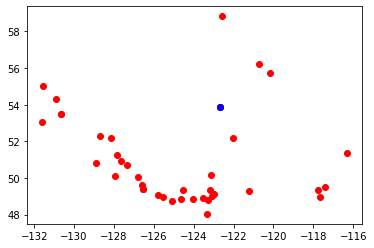

In [32]:
plt.plot(stn_lon[flag_pick][UNET_JRA_BC_ind[-40:]], stn_lat[flag_pick][UNET_JRA_BC_ind[-40:]], 'ro')
plt.plot(stn_lon[flag_pick][UNET_JRA_BC_ind[65]], stn_lat[flag_pick][UNET_JRA_BC_ind[65]], 'bo')
#plt.plot(stn_lon[flag_us][UNET_JRA_US_ind[75:77]], stn_lat[flag_us][UNET_JRA_US_ind[75:77]], 'bo')

In [33]:
idaho_pick = du.check_bounds_2d(stn_lon[flag_us][UNET_JRA_US_ind[-40:]], stn_lat[flag_us][UNET_JRA_US_ind[-40:]], [-117, -109, 40, 46])

In [34]:
stn_code[flag_us][UNET_JRA_US_ind[-40:]][idaho_pick]

array(['USW00024156', 'USR0000IRAF', 'USR0000IISP', 'USR0000WBEC',
       'USR0000IROC'], dtype=object)

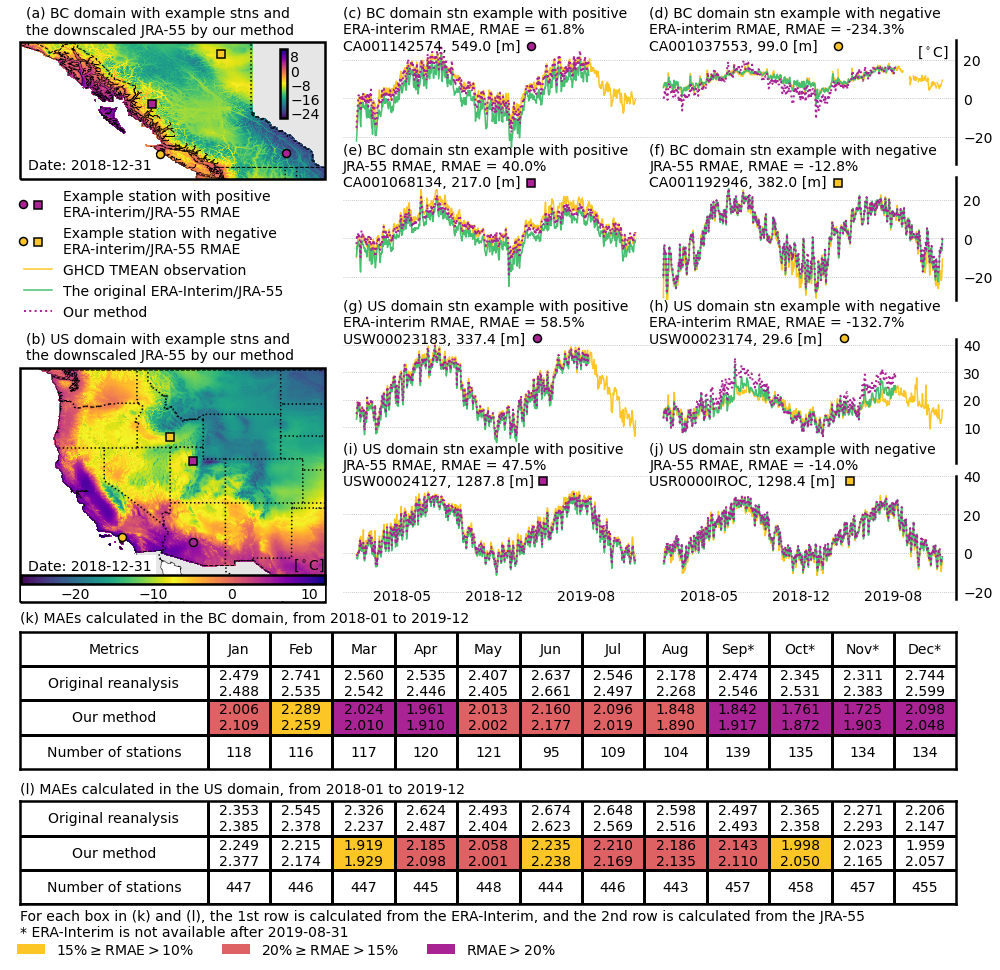

In [89]:
edge = [-140, -100, 28, 59.5]
rate = 0.725
edge_US = [-1*(48-28)/rate-100, edge[1], edge[2], 48.6]
edge_BC = [edge[0], -141+(68.4-48.5)/rate, 48, edge[3]]
edges = (edge_BC, edge_US)
fig = plt.figure(figsize=(13, 12))

gs = gridspec.GridSpec(9, 4, height_ratios=[0.9, 0.9, 0.1, 0.9, 0.9, 0.05, 1, 0.05, 0.75], width_ratios=[1, 0.05, 1, 1])
ax_blank1 = plt.subplot(gs[:2, 0])
ax_gap1 = plt.subplot(gs[:2, 1])
ax2 = plt.subplot(gs[0, 2])
ax3 = plt.subplot(gs[0, 3])
ax4 = plt.subplot(gs[1:2, 2])
ax5 = plt.subplot(gs[1:2, 3])
ax_gap2 = plt.subplot(gs[2, :])
#ax_blank2 = plt.subplot(gs[3:5, 0])
ax_gap3 = plt.subplot(gs[3:5, 1])
ax7 = plt.subplot(gs[3, 2])
ax8 = plt.subplot(gs[3, 3])
ax9 = plt.subplot(gs[4, 2])
ax10 = plt.subplot(gs[4, 3])
ax_gap4 = plt.subplot(gs[5, :])
ax11 = plt.subplot(gs[6, :])
ax_gap5 = plt.subplot(gs[7, :])
ax12 = plt.subplot(gs[8, :])
plt.subplots_adjust(0, 0, 1, 1, hspace=0.15, wspace=0)

ax_blank1.set_axis_off()

ax1 = fig.add_axes([0, 0.8185, 0.326, 0.2], projection=ccrs.PlateCarree()) #0.326
ax6 = fig.add_axes([0, 0.335, 0.326, 0.3], projection=ccrs.PlateCarree())

AX_map = [ax1, ax6]
map_titles = ['(a) BC domain with example stns and\nthe downscaled JRA-55 by our method', 
              '(b) US domain with example stns and\nthe downscaled JRA-55 by our method']
map_locx = [0.018]*2
map_locy = [1.265, 1.155]
map_locy2 = [0.05, 0.125]
AX_lines = [ax2, ax3, ax4, ax5, ax7, ax8, ax9, ax10]
line_titles = ['(c) BC domain stn example with positive\nERA-interim RMAE, RMAE = {:.1f}%\n{}, {} [m]',
               '(d) BC domain stn example with negative\nERA-interim RMAE, RMAE = {:.1f}%\n{}, {} [m]',
               '(e) BC domain stn example with positive\nJRA-55 RMAE, RMAE = {:.1f}%\n{}, {} [m]',
               '(f) BC domain stn example with negative\nJRA-55 RMAE, RMAE = {:.1f}%\n{}, {} [m]',
               '(g) US domain stn example with positive\nERA-interim RMAE, RMAE = {:.1f}%\n{}, {} [m]',
               '(h) US domain stn example with negative\nERA-interim RMAE, RMAE = {:.1f}%\n{}, {} [m]',
               '(i) US domain stn example with positive\nJRA-55 RMAE, RMAE = {:.1f}%\n{}, {} [m]',
               '(j) US domain stn example with negative\nJRA-55 RMAE, RMAE = {:.1f}%\n{}, {} [m]']

line_locx = [0]*8
line_locy = [1.275, 1.275, 1.275, 1.275, 1.325, 1.325, 1.275, 1.275]

order_id = [0, 6, 40, 59, 0, 3, 41, 79]

line_lon = [stn_lon[flag_pick][UNET_ERA_BC_ind[order_id[0]]],
            stn_lon[flag_pick][UNET_JRA_BC_ind[order_id[1]]],
            stn_lon[flag_pick][UNET_ERA_BC_ind[order_id[2]]],
            stn_lon[flag_pick][UNET_JRA_BC_ind[order_id[3]]],
            stn_lon[flag_us][UNET_ERA_US_ind[order_id[4]]],
            stn_lon[flag_us][UNET_JRA_US_ind[order_id[5]]],
            stn_lon[flag_us][UNET_ERA_US_ind[order_id[6]]],
            stn_lon[flag_us][UNET_JRA_US_ind[order_id[7]]]]

line_lat = [stn_lat[flag_pick][UNET_ERA_BC_ind[order_id[0]]],
            stn_lat[flag_pick][UNET_JRA_BC_ind[order_id[1]]],
            stn_lat[flag_pick][UNET_ERA_BC_ind[order_id[2]]],
            stn_lat[flag_pick][UNET_JRA_BC_ind[order_id[3]]],
            stn_lat[flag_us][UNET_ERA_US_ind[order_id[4]]],
            stn_lat[flag_us][UNET_JRA_US_ind[order_id[5]]],
            stn_lat[flag_us][UNET_ERA_US_ind[order_id[6]]],
            stn_lat[flag_us][UNET_JRA_US_ind[order_id[7]]]]

line_code = [stn_code[flag_pick][UNET_ERA_BC_ind[order_id[0]]],
             stn_code[flag_pick][UNET_ERA_BC_ind[order_id[2]]],
             stn_code[flag_pick][UNET_JRA_BC_ind[order_id[1]]],
             stn_code[flag_pick][UNET_JRA_BC_ind[order_id[3]]],
             stn_code[flag_us][UNET_ERA_US_ind[order_id[4]]],
             stn_code[flag_us][UNET_ERA_US_ind[order_id[6]]],
             stn_code[flag_us][UNET_JRA_US_ind[order_id[5]]],
             stn_code[flag_us][UNET_JRA_US_ind[order_id[7]]]]

line_elev = [stn_elev[flag_pick][UNET_ERA_BC_ind[order_id[0]]],
             stn_elev[flag_pick][UNET_ERA_BC_ind[order_id[2]]],
             stn_elev[flag_pick][UNET_JRA_BC_ind[order_id[1]]],
             stn_elev[flag_pick][UNET_JRA_BC_ind[order_id[3]]],
             stn_elev[flag_us][UNET_ERA_US_ind[order_id[4]]],
             stn_elev[flag_us][UNET_ERA_US_ind[order_id[6]]],
             stn_elev[flag_us][UNET_JRA_US_ind[order_id[5]]],
             stn_elev[flag_us][UNET_JRA_US_ind[order_id[7]]]]

line_RMAE = [RMAE_series_ERA[flag_pick][UNET_ERA_BC_ind[order_id[0]]],
             RMAE_series_JRA[flag_pick][UNET_ERA_BC_ind[order_id[2]]],
             RMAE_series_ERA[flag_pick][UNET_JRA_BC_ind[order_id[1]]],
             RMAE_series_JRA[flag_pick][UNET_JRA_BC_ind[order_id[3]]],
             RMAE_series_ERA[flag_us][UNET_ERA_US_ind[order_id[4]]],
             RMAE_series_JRA[flag_us][UNET_ERA_US_ind[order_id[6]]],
             RMAE_series_ERA[flag_us][UNET_JRA_US_ind[order_id[5]]],
             RMAE_series_JRA[flag_us][UNET_JRA_US_ind[order_id[7]]]]

ax_blank.set_axis_off()
ax_gap1.set_axis_off()
ax_gap2.set_axis_off()
ax_gap3.set_axis_off()
ax_gap4.set_axis_off()
ax_gap5.set_axis_off()

for i, ax in enumerate(AX_map):
    ax.set_extent(edges[i], ccrs.Geodetic())
    ax.add_feature(cfeature.LAND.with_scale(scale_param), facecolor='0.9')
    ax.add_feature(cfeature.COASTLINE.with_scale(scale_param), edgecolor='k', linewidth=0.5, zorder=1.0)
    ax.add_feature(cfeature.BORDERS.with_scale(scale_param), edgecolor='k', linestyle='--', linewidth=1.0)
    ax.add_feature(PROVINCE, edgecolor='k', linestyle=':', linewidth=1.5, zorder=1.0)
    ax.outline_patch.set_linewidth(2.5)
    handle_box = ax.text(map_locx[i], map_locy[i], map_titles[i], fontsize=14, ha='left', va='top', transform=ax.transAxes)
    handle_box.set_bbox(dict(facecolor='w', alpha=1, edgecolor='none'))
    handle_box = ax.text(0.025, map_locy2[i], 'Date: 2018-12-31', fontsize=14, ha='left', va='bottom', transform=ax.transAxes)
    handle_box.set_bbox(dict(facecolor='w', alpha=1, edgecolor='none'))

handle_box = ax.text(1.0, map_locy2[i], '[$\mathsf{^\circ C}$]', fontsize=14, ha='right', va='bottom', transform=ax.transAxes)
handle_box.set_bbox(dict(facecolor='none', alpha=1, edgecolor='none'))   

    
YLIMs = [[-34, 30], [-34, 30], 
         [-32, 32], [-32, 32], 
         [-3, 42], [-3, 42], 
         [-24, 40], [-24, 40]]

for i, ax in enumerate(AX_lines):
    ax.grid(linestyle=':'); ax.xaxis.grid(False)
    ax.spines["left"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.spines["bottom"].set_visible(False)
    ax.spines["top"].set_visible(False)
    ax.xaxis.set_tick_params(labelsize=14)
    ax.yaxis.set_tick_params(labelsize=14)
    [j.set_linewidth(2.5) for j in ax.spines.values()]
    ax.tick_params(axis="both", which="both", bottom=False, top=False, labelbottom=False, left=False, right=False, labelleft=False)
    ax.set_ylim(YLIMs[i])
    if i == 4 or i == 5:
        ax.set_yticks([10, 20, 30, 40])
    handle_box = ax.text(line_locx[i], line_locy[i], line_titles[i].format(line_RMAE[i], line_code[i], line_elev[i]), 
                         fontsize=14, ha='left', va='top', transform=ax.transAxes)
    handle_box.set_bbox(dict(facecolor='none', alpha=1, edgecolor='none'))
    
Ms = ['o', 'o', 's', 's']*2
Cs = [C1, C2, C1, C2]*2
Ds = [0.33]*2+[0.34]*2+[0.325]*2+[0.33]*2
Xs = [0.58]*4+[0.60]*2+[0.62]*2
for i, ax in enumerate(AX_lines):
    ax_in = inset_axes(ax, width='100%', height='100%', 
                       bbox_to_anchor=(Xs[i], line_locy[i]-Ds[i], 0.1, 0.1), bbox_transform=ax.transAxes)
    ax_in.plot(0, 0, Ms[i], ms=8, mew=1.5, mec='k', mfc=Cs[i])
    ax_in.set_axis_off()
    
ticks = [120, 360, 600]
labels = []
for tick in ticks:
    labels.append(datetime.strftime(pred_list_jra[tick], '%Y-%m'))
for ax in AX_lines[-2:]:
    ax.tick_params(axis="x", labelbottom=True, direction='in', pad=-10)
    ax.set_xticks(ticks)
    ax.set_xticklabels(labels)

for i, ax in enumerate(AX_lines[1::2]):
    ax.spines["right"].set_visible(True)
    ax.tick_params(labelright=True)

for ax in [ax11, ax12]:
    ax = gu.ax_decorate_box(ax)
    
CS2 = AX_map[0].pcolormesh(lon_4km, lat_4km, JRA_4km[365, ...], vmin=-17, vmax=12, cmap=camp_t2)
CS2 = AX_map[1].pcolormesh(lon_4km, lat_4km, JRA_4km[365, ...], vmin=-27, vmax=12, cmap=camp_t2)

dot_handle = []
AX_map[0].plot(line_lon[0], line_lat[0], 'o', ms=8, mew=1.5, mec='k', mfc=C1)
dot_handle += AX_map[0].plot(line_lon[1], line_lat[1], 's', ms=8, mew=1.5, mec='k', mfc=C1, 
                             label='Example station with positive\nERA-interim/JRA-55 RMAE')
AX_map[0].plot(line_lon[2], line_lat[2], 'o', ms=8, mew=1.5, mec='k', mfc=C2)
dot_handle += AX_map[0].plot(line_lon[3], line_lat[3], 's', ms=8, mew=1.5, mec='k', mfc=C2, 
                             label='Example station with negative\nERA-interim/JRA-55 RMAE')

AX_map[1].plot(line_lon[4], line_lat[4], 'o', ms=8, mew=1.5, mec='k', mfc=C1)
AX_map[1].plot(line_lon[5], line_lat[5], 's', ms=8, mew=1.5, mec='k', mfc=C1)
AX_map[1].plot(line_lon[6], line_lat[6], 'o', ms=8, mew=1.5, mec='k', mfc=C2)
AX_map[1].plot(line_lon[7], line_lat[7], 's', ms=8, mew=1.5, mec='k', mfc=C2)


AX_lines[1].text(0.975, 0.975, '[$\mathsf{^\circ C}$]', va='top', ha='right', fontsize=14, transform=AX_lines[1].transAxes)

s = ':'
w = 2.0
line_handle = []
line_handle += AX_lines[0].plot(fake_x, OBS[:, flag_pick][:, UNET_ERA_BC_ind[order_id[0]]], color=C2, label='GHCD TMEAN observation')
line_handle += AX_lines[0].plot(fake_x[:N_pred_era], -1+RAW_ERA[:, flag_pick][:, UNET_ERA_BC_ind[order_id[0]]], 
                                color=C3, label='The original ERA-Interim/JRA-55')
line_handle += AX_lines[0].plot(fake_x[:N_pred_era], UNET_ERA[:, flag_pick][:, UNET_ERA_BC_ind[order_id[0]]], 
                                ls=s, lw=w, color=C1, label='Our method')

AX_lines[1].plot(fake_x, OBS[:, flag_pick][:, UNET_ERA_BC_ind[order_id[2]]], color=C2)
AX_lines[1].plot(fake_x[:N_pred_era], RAW_ERA[:, flag_pick][:, UNET_ERA_BC_ind[order_id[2]]], color=C3)
AX_lines[1].plot(fake_x[:N_pred_era], UNET_ERA[:, flag_pick][:, UNET_ERA_BC_ind[order_id[2]]], ls=s, lw=w, color=C1)

AX_lines[2].plot(fake_x, OBS[:, flag_pick][:, UNET_JRA_BC_ind[order_id[1]]], color=C2)
AX_lines[2].plot(fake_x, -1+RAW_JRA[:, flag_pick][:, UNET_JRA_BC_ind[order_id[1]]], color=C3)
AX_lines[2].plot(fake_x, UNET_JRA[:, flag_pick][:, UNET_JRA_BC_ind[order_id[1]]], ls=s, lw=w, color=C1)

AX_lines[3].plot(fake_x, OBS[:, flag_pick][:, UNET_JRA_BC_ind[order_id[3]]], color=C2)
AX_lines[3].plot(fake_x, RAW_JRA[:, flag_pick][:, UNET_JRA_BC_ind[order_id[3]]], color=C3)
AX_lines[3].plot(fake_x, UNET_JRA[:, flag_pick][:, UNET_JRA_BC_ind[order_id[3]]], ls=s, lw=w, color=C1)

AX_lines[4].plot(fake_x, OBS[:, flag_us][:, UNET_ERA_US_ind[order_id[4]]], color=C2)
AX_lines[4].plot(fake_x[:N_pred_era], RAW_ERA[:, flag_us][:, UNET_ERA_US_ind[order_id[4]]], color=C3)
AX_lines[4].plot(fake_x[:N_pred_era], UNET_ERA[:, flag_us][:, UNET_ERA_US_ind[order_id[4]]], ls=s, lw=w, color=C1)

AX_lines[5].plot(fake_x, OBS[:, flag_us][:, UNET_ERA_US_ind[order_id[6]]], color=C2)
AX_lines[5].plot(fake_x[:N_pred_era], RAW_ERA[:, flag_us][:, UNET_ERA_US_ind[order_id[6]]], color=C3)
AX_lines[5].plot(fake_x[:N_pred_era], UNET_ERA[:, flag_us][:, UNET_ERA_US_ind[order_id[6]]], ls=s, lw=w, color=C1)

AX_lines[6].plot(fake_x, OBS[:, flag_us][:, UNET_JRA_US_ind[order_id[5]]], color=C2)
AX_lines[6].plot(fake_x, RAW_JRA[:, flag_us][:, UNET_JRA_US_ind[order_id[5]]], color=C3)
AX_lines[6].plot(fake_x, UNET_JRA[:, flag_us][:, UNET_JRA_US_ind[order_id[5]]], ls=s, lw=w, color=C1)

AX_lines[7].plot(fake_x, OBS[:, flag_us][:, UNET_JRA_US_ind[order_id[7]]], color=C2)
AX_lines[7].plot(fake_x, RAW_JRA[:, flag_us][:, UNET_JRA_US_ind[order_id[7]]], color=C3)
AX_lines[7].plot(fake_x, UNET_JRA[:, flag_us][:, UNET_JRA_US_ind[order_id[7]]], ls=s, lw=w, color=C1)

ax_lg = fig.add_axes([0, 0.6775, 0.295, 0.165])
ax_lg.set_axis_off()
LG = ax_lg.legend(handles=dot_handle+line_handle, bbox_to_anchor=(1, 1), fancybox=False, ncol=1, prop={'size':14})
LG.get_frame().set_facecolor('none')
LG.get_frame().set_edgecolor('k')
LG.get_frame().set_linewidth(0)

ax_in = inset_axes(ax, width='100%', height='100%', 
                       bbox_to_anchor=(-0.025, 0.3375, 0.1, 0.1), bbox_transform=ax_blank1.transAxes)
ax_in.plot(0, 0, 'o', ms=8, mew=1.5, mec='k', mfc=C1)
ax_in.set_axis_off()

ax_in = inset_axes(ax, width='100%', height='100%', 
                       bbox_to_anchor=(-0.025, 0.196, 0.1, 0.1), bbox_transform=ax_blank1.transAxes)
ax_in.plot(0, 0, 'o', ms=8, mew=1.5, mec='k', mfc=C2)
ax_in.set_axis_off()


ax_base = fig.add_axes([0.326-0.06, 0.91, 0.03, 0.08])
[j.set_linewidth(0) for j in ax_base.spines.values()]
ax_base.tick_params(axis='both', left=False, top=False, right=False, bottom=False, \
                    labelleft=False, labeltop=False, labelright=False, labelbottom=False)
ax_base.set_facecolor('0.9')
cax = inset_axes(ax_base, height='100%', width='25%', borderpad=0, loc=9)
CBar = plt.colorbar(CS1, orientation='vertical', cax=cax)
CBar.ax.tick_params(axis='y', labelsize=14, direction='in', length=0)
tick_locator = ticker.MaxNLocator(nbins=5)
CBar.locator = tick_locator
CBar.update_ticks()
CBar.outline.set_linewidth(2.5)

ax_base2 = fig.add_axes([1e-3, 0.3515, 0.324, 0.03])
[j.set_linewidth(0) for j in ax_base2.spines.values()]
ax_base2.tick_params(axis='both', left=False, top=False, right=False, bottom=False, \
                    labelleft=False, labeltop=False, labelright=False, labelbottom=False)
cax2 = inset_axes(ax_base2, width='100%', height='35%', borderpad=0, loc=9)
CBar2 = plt.colorbar(CS2, orientation='horizontal', cax=cax2) 
CBar2.ax.tick_params(axis='x', labelsize=14, direction='in', length=0)
CBar2.outline.set_linewidth(2.5)

pad = 0.2
x_coord = np.zeros(14)
x_coord[0] = 0
x_coord[1] = pad
x_coord[2:] = np.linspace(pad, 1, 13)[1:]

y_coord1 = np.linspace(0, 1, 5)
y_coord1 = y_coord1[::-1]

y_coord2 = np.linspace(0, 1, 4)
y_coord2 = y_coord2[::-1]

table_content_h = ['Metrics', 'Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep*', 'Oct*', 'Nov*', 'Dec*']
tabel_centent_v1 = ['Original reanalysis', 'Our method', 'Number of stations']
tabel_centent_v2 = ['Original reanalysis', 'Our method', 'Number of stations']

text_C = [C2, plt.cm.plasma(150), C1]
# ----- BC ----- #
ax_table = ax11
ax_table.text(0, 1.05, '(k) MAEs calculated in the BC domain, from 2018-01 to 2019-12', 
              fontsize=14, ha='left', va='bottom', transform=ax_table.transAxes)
for i, word in enumerate(table_content_h):
        ax_table.text(0.5*(x_coord[i]+x_coord[i+1]), 0.5*(y_coord1[0]+y_coord1[1]), word, 
                      va='center', ha='center', fontsize=14, transform=ax_table.transAxes)
        
for i, word in enumerate(tabel_centent_v1):
    ax_table.text(0.5*(x_coord[0]+x_coord[1]), 0.5*(y_coord1[i+1]+y_coord1[i+2]), word, 
                  va='center', ha='center', fontsize=14, transform=ax_table.transAxes)

for i in range(12):
    for j in range(3):
        if j == 1:
            # boxes
            points = [[x_coord[i+1], y_coord1[j+1]], [x_coord[i+1], y_coord1[j+2]], 
                      [x_coord[i+2], y_coord1[j+2]], [x_coord[i+2], y_coord1[j+1]]]
            if RMAE_BC[i] > 0.1 and RMAE_BC[i] < 0.15:
                boxes = PatchCollection([patches.Polygon(points)], facecolor=text_C[0], 
                                        edgecolor='none', linewidth=0, transform=ax_table.transAxes)
                ax_table.add_collection(boxes)
            elif RMAE_BC[i] > 0.15 and RMAE_BC[i] < 0.2:
                boxes = PatchCollection([patches.Polygon(points)], facecolor=text_C[1], 
                                        edgecolor='none', linewidth=0, transform=ax_table.transAxes)
                ax_table.add_collection(boxes)
            elif RMAE_BC[i] > 0.2:
                boxes = PatchCollection([patches.Polygon(points)], facecolor=text_C[2], 
                                        edgecolor='none', linewidth=0, transform=ax_table.transAxes)
                ax_table.add_collection(boxes)

        # lines
        ax_table.axvline(x_coord[i+1], ymin=0, ymax=1, lw='2.5', color='k')
        ax_table.axhline(y_coord1[j+1], xmin=0, xmax=1, lw='2.5', color='k')
        # values
        if j == 2:
            ax_table.text(0.5*(x_coord[i+1]+x_coord[i+2]), 0.5*(y_coord1[j+1]+y_coord1[j+2]), 
                          '{}'.format(int(table_BC_JRA[j, i])), 
                          ha='center', va='center', fontsize=14, transform=ax_table.transAxes)
        else:
            ax_table.text(0.5*(x_coord[i+1]+x_coord[i+2]), 0.5*(y_coord1[j+1]+y_coord1[j+2]), 
                          '{:.3f}\n{:.3f}'.format(table_BC_ERA[j, i], table_BC_JRA[j, i]), 
                          ha='center', va='center', fontsize=14, transform=ax_table.transAxes)
# ----- US ----- #
ax_table = ax12
ax_table.text(0, 1.05, '(l) MAEs calculated in the US domain, from 2018-01 to 2019-12', 
             fontsize=14, ha='left', va='bottom', transform=ax_table.transAxes)
ax_table = ax12
for i, word in enumerate(tabel_centent_v2): 
    ax_table.text(0.5*(x_coord[0]+x_coord[1]), 0.5*(y_coord2[i]+y_coord2[i+1]), word, 
                  va='center', ha='center', fontsize=14, transform=ax_table.transAxes)
for i in range(12):
    for j in range(3):
        if j == 1:
            # boxes
            points = [[x_coord[i+1], y_coord2[j]], [x_coord[i+1], y_coord2[j+1]], 
                      [x_coord[i+2], y_coord2[j+1]], [x_coord[i+2], y_coord2[j]]]
            if RMAE_US[i] > 0.1 and RMAE_US[i] < 0.15:
                boxes = PatchCollection([patches.Polygon(points)], facecolor=text_C[0], 
                                        edgecolor='none', linewidth=0, transform=ax_table.transAxes)
                ax_table.add_collection(boxes)
            elif RMAE_US[i] > 0.15 and RMAE_US[i] < 0.2:
                boxes = PatchCollection([patches.Polygon(points)], facecolor=text_C[1], 
                                        edgecolor='none', linewidth=0, transform=ax_table.transAxes)
                ax_table.add_collection(boxes)
            elif RMAE_US[i] > 0.2:
                boxes = PatchCollection([patches.Polygon(points)], facecolor=text_C[2], 
                                        edgecolor='none', linewidth=0, transform=ax_table.transAxes)
                ax_table.add_collection(boxes)
            elif RMAE_US[i] < 0:
                boxes = PatchCollection([patches.Polygon(points)], facecolor=C3, 
                                        edgecolor='none', linewidth=0, transform=ax_table.transAxes)
                ax_table.add_collection(boxes)

        ax_table.axvline(x_coord[i+1], ymin=0, ymax=1, lw='2.5', color='k')
        ax_table.axhline(y_coord2[j+1], xmin=0, xmax=1, lw='2.5', color='k')
        if j == 2:
            ax_table.text(0.5*(x_coord[i+1]+x_coord[i+2]), 0.5*(y_coord2[j]+y_coord2[j+1]), 
                          '{}'.format(int(table_US_JRA[j, i])), 
                          ha='center', va='center', fontsize=14, transform=ax_table.transAxes)
        else:
            ax_table.text(0.5*(x_coord[i+1]+x_coord[i+2]), 0.5*(y_coord2[j]+y_coord2[j+1]),
                          '{:.3f}\n{:.3f}'.format(table_US_ERA[j, i], table_US_JRA[j, i]),
                          ha='center', va='center', fontsize=14, transform=ax_table.transAxes)
ax_table.text(0, -0.05, 
              'For each box in (k) and (l), the 1st row is calculated from the ERA-Interim, and the 2nd row is calculated from the JRA-55', 
         fontsize=14, ha='left', va='top');
ax_table.text(0, -0.2, '* ERA-Interim is not available after 2019-08-31',
         fontsize=14, ha='left', va='top');
legend_roc = []
legend_roc.append(patches.Patch(facecolor=text_C[0], label='15%$\mathsf{\geq}$RMAE$\mathsf{>}$10%'))
legend_roc.append(patches.Patch(facecolor=text_C[1], label='20%$\mathsf{\geq}$RMAE$\mathsf{>}$15%'))
legend_roc.append(patches.Patch(facecolor=text_C[2], label='RMAE$\mathsf{>}$20%'))

ax_lg = fig.add_axes([-0.014, -0.058, 0.6, 0.0275])
ax_lg.set_axis_off()
LG = ax_lg.legend(handles=legend_roc, bbox_to_anchor=(1, 1), ncol=4, prop={'size':14});
LG.get_frame().set_facecolor('white')
LG.get_frame().set_edgecolor('k')
LG.get_frame().set_linewidth(0)

# Save figure
fig.savefig(fig_dir+'CGAN_stn_compare.png', format='png', **fig_keys)

In [53]:
N_date = 365 + 365 + 366 + 365 + 365 + 365
date_list = [datetime(2014, 1, 1, 0) + timedelta(days=x) for x in range(N_date)]

In [54]:
t = np.arange(N_date)

In [55]:
train_l = 365 + 365 + 366 + 365
date_dict = {
    ' ':[0, 0, 0],
    '  ':[0, 0, 0],
    'GHCN daily':[365 + 365 + 366 + 365, 0, 365 + 365],
    'PRISM': [365, 365 + 366 + 365, 0],
    'JRA': [train_l, 0, 365 + 365],
    'ERA': [0, train_l, 365 + 243]}

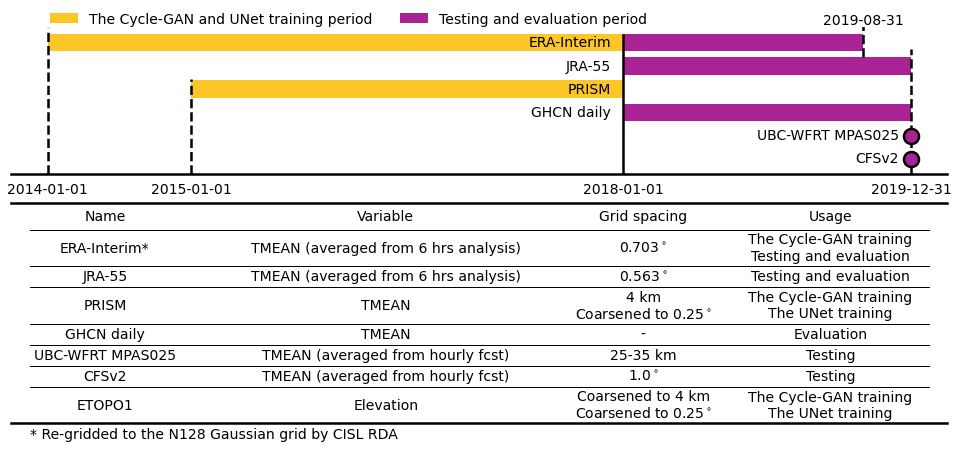

In [56]:
fig = plt.figure(figsize=(13, 5.5))

gs = gridspec.GridSpec(3, 1, height_ratios=[0.5, 0.1, 0.75])

ax1 = plt.subplot(gs[0, :])
ax2 = plt.subplot(gs[2, :])
ax_gap = plt.subplot(gs[1, :])
plt.subplots_adjust(0, 0, 1, 1, hspace=0, wspace=0)

ax_gap.set_axis_off()

for ax in [ax1, ax2]:
    ax = gu.ax_decorate_box(ax)

    
ax1.spines["left"].set_visible(False)
ax1.spines["right"].set_visible(False)
ax1.spines["top"].set_visible(False)
ax1.set_xlim(-92, N_date+92)


labels = list(date_dict.keys())
data = np.array(list(date_dict.values()))
data_cum = data.cumsum(axis=1)
colors = ['w', C2, C1]
words = ['The Cycle-GAN and UNet training period', 'Testing and evaluation period']
handle = []
for i in range(3):
    if i == 0:
        ax1.barh(labels, data[:, i], left=data_cum[:, i]-data[:, i], color=colors[i], height=0.75)
    else:
        handle += ax1.barh(labels, data[:, i], left=data_cum[:, i]-data[:, i], color=colors[i], height=0.75, label=words[i-1])

ax1.plot(N_date, 0, 'o', ms=15, mfc=C1, mew=2.5, mec='k', zorder=4)
ax1.plot(N_date, 1, 'o', ms=15, mfc=C1, mew=2.5, mec='k', zorder=4)      
ax1.axvline(x=train_l, ymin=0, ymax=0.95, lw=2.5, color='k')
ax1.axvline(x=0, ymin=0, ymax=5/5, lw=2.5, color='k', ls='--')
ax1.axvline(x=365, ymin=0, ymax=3/5+0.05, lw=2.5, color='k', ls='--')
ax1.axvline(x=N_date, ymin=0, ymax=4/5+0.05, lw=2.5, color='k', ls='--')
ax1.axvline(x=train_l+365 + 243, ymin=4/5, ymax=5/5+0.05, lw=2.5, color='k', ls='--')

ax1.text(0, -1, '2014-01-01', ha='center', va='top', fontsize=14)
ax1.text(365, -1, '2015-01-01', ha='center', va='top', fontsize=14)
ax1.text(train_l, -1, '2018-01-01', ha='center', va='top', fontsize=14)
ax1.text(N_date, -1, '2019-12-31', ha='center', va='top', fontsize=14)
ax1.text(train_l+365+243, 6.25, '2019-08-31', ha='center', va='top', fontsize=14)

ax1.text(train_l-31, 5, 'ERA-Interim', ha='right', va='center', fontsize=14)
ax1.text(train_l-31, 4, 'JRA-55', ha='right', va='center', fontsize=14)
ax1.text(train_l-31, 3, 'PRISM', ha='right', va='center', fontsize=14)
ax1.text(train_l-31, 2, 'GHCN daily', ha='right', va='center', fontsize=14)
ax1.text(N_date-31, 1, 'UBC-WFRT MPAS025', ha='right', va='center', fontsize=14)
ax1.text(N_date-31, 0, 'CFSv2', ha='right', va='center', fontsize=14)

LG = ax1.legend(bbox_to_anchor=(0.0275, 1.19), ncol=2, prop={'size':14}, loc='upper left', fancybox=False)#
LG.get_frame().set_facecolor('white')
LG.get_frame().set_edgecolor('k')
LG.get_frame().set_linewidth(0)

ax2.spines["left"].set_visible(False)
ax2.spines["right"].set_visible(False)

HEAD = ['Name', 'Variable', 'Grid spacing', 'Usage']
NAME = ['ERA-Interim*', 'JRA-55', 'PRISM', 'GHCN daily', 'UBC-WFRT MPAS025', 'CFSv2', 'ETOPO1']
Vars = ['TMEAN (averaged from 6 hrs analysis)', 'TMEAN (averaged from 6 hrs analysis)', 
        'TMEAN', 'TMEAN', 'TMEAN (averaged from hourly fcst)', 'TMEAN (averaged from hourly fcst)', 'Elevation']
Grid = ['0.703$\mathsf{^\circ}$', '0.563$\mathsf{^\circ}$', '4 km\nCoarsened to 0.25$\mathsf{^\circ}$', 
        '-', '25-35 km', '1.0$\mathsf{^\circ}$', 'Coarsened to 4 km\nCoarsened to 0.25$\mathsf{^\circ}$']
Uses = ['The Cycle-GAN training\nTesting and evaluation', 'Testing and evaluation', 
        'The Cycle-GAN training\nThe UNet training', 
        'Evaluation', 'Testing', 'Testing', 'The Cycle-GAN training\nThe UNet training']

table_width = [0, 0.2, 0.6, 0.75, 1.0]
#table_height = list(np.array([0, 0.2, 0.3, 0.4, 0.6, 0.7, 0.9, 1.1])*(1/1.1))
table_height = list(np.array([0, 0.175, 0.275, 0.375, 0.475, 0.65, 0.75, 0.925, 1.05])*(1/1.05))

table_height = table_height[::-1]
for i in range(4):
    #ax2.axvline(table_width[i], ymin=0, ymax=1.0, lw=2.5, color='k')
    ax2.text(0.5*(table_width[i]+table_width[i+1]), 0.5*(table_height[0]+table_height[1]), HEAD[i], 
             fontsize=14, ha='center', va='center', transform=ax2.transAxes)

for i in range(7):
    ax2.axhline(table_height[i], xmin=0.02, xmax=0.98, lw=1.0, color='k')
    ax2.text(0.5*(table_width[1]+table_width[0]), 0.5*(table_height[i+1]+table_height[i+2]), NAME[i], 
             fontsize=14, ha='center', va='center', transform=ax2.transAxes)
    ax2.text(0.5*(table_width[2]+table_width[1]), 0.5*(table_height[i+1]+table_height[i+2]), Vars[i], 
             fontsize=14, ha='center', va='center', transform=ax2.transAxes)
    ax2.text(0.5*(table_width[3]+table_width[2]), 0.5*(table_height[i+1]+table_height[i+2]), Grid[i], 
             fontsize=14, ha='center', va='center', transform=ax2.transAxes)
    ax2.text(0.5*(table_width[4]+table_width[3]), 0.5*(table_height[i+1]+table_height[i+2]), Uses[i], 
             fontsize=14, ha='center', va='center', transform=ax2.transAxes)
ax2.axhline(table_height[-2], xmin=0.02, xmax=0.98, lw=1.0, color='k')

ax2.text(0.02, -0.02, '* Re-gridded to the N128 Gaussian grid by CISL RDA', ha='left', va='top', fontsize=14, transform=ax2.transAxes)

# Save figure
fig.savefig(fig_dir+'CGAN_data_source.png', format='png', **fig_keys)